- https://github.com/tencent-ailab/IP-Adapter/blob/main/ip_adapter_demo.ipynb
- https://github.com/tencent-ailab/IP-Adapter/blob/main/ip_adapter_multimodal_prompts_demo.ipynb

In [1]:
from google.colab import files

uploaded = files.upload()

Saving statue.png to statue.png
Saving woman.png to woman.png


In [2]:
!pip install -q transformers

import transformers

transformers.utils.move_cache()
# The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.2 MB/s eta 0:00:00


0it [00:00, ?it/s]

In [3]:
# !pip uninstall -q diffusers --yes
!pip install -q diffusers==0.22.1

import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, \
DDIMScheduler, AutoencoderKL
from PIL import Image

# IF AN ERROR IS ENCOUNTERED, RESTART RUNTIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00


In [4]:
%cd /content
!git clone https://github.com/tencent-ailab/IP-Adapter.git
%cd IP-Adapter
!git lfs install
# !git clone https://huggingface.co/h94/IP-Adapter
# %mv IP-Adapter/models models
# %mv IP-Adapter/sdxl_models sdxl_models
%mkdir hf-models
%cd hf-models
!git init
!git remote add origin https://huggingface.co/h94/IP-Adapter
!git config core.sparseCheckout true
!echo "models/" >> .git/info/sparse-checkout
!git pull origin main
%cd ..
%mv hf-models/models models
# !git clone https://huggingface.co/runwayml/stable-diffusion-v1-5
%mkdir stable-diffusion-v1-5
%cd stable-diffusion-v1-5
!git init
!git remote add origin https://huggingface.co/runwayml/stable-diffusion-v1-5
!git config core.sparseCheckout true
!echo "v1-5-pruned-emaonly.safetensors" >> .git/info/sparse-checkout
!git pull origin main
%cd ..
# !git clone https://huggingface.co/SG161222/Realistic_Vision_V4.0_noVAE
%mkdir Realistic_Vision_V4.0_noVAE
%cd Realistic_Vision_V4.0_noVAE
!git init
!git remote add origin https://huggingface.co/SG161222/Realistic_Vision_V4.0_noVAE
!git config core.sparseCheckout true
!echo "Realistic_Vision_V4.0.safetensors" >> .git/info/sparse-checkout
!git pull origin main
%cd ..
!git clone https://huggingface.co/stabilityai/sd-vae-ft-mse

/content
Cloning into 'IP-Adapter'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 336 (delta 113), reused 133 (delta 90), pack-reused 164
Receiving objects: 100% (336/336), 76.74 MiB | 23.08 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/content/IP-Adapter
Updated git hooks.
Git LFS initialized.
/content/IP-Adapter/hf-models
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/IP-Adapter/hf-models/.git/
re

In [5]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [6]:
from ip_adapter import IPAdapter

In [7]:
# base_model_path = "runwayml/stable-diffusion-v1-5"
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter_sd15.bin"
device = "cuda"

In [8]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [14]:
def concat_resized_images(images, height=256):
    resized_images = []
    for img in images:
        ratio = img.width / img.height
        new_width = int(ratio * height)
        resized_image = img.resize((new_width, height), Image.ANTIALIAS)
        resized_images.append(resized_image)

    total_width = sum(img.width for img in resized_images)

    # create a new blank image with total width
    new_image = Image.new('RGB', (total_width, height))

    # paste each image into the new image
    x_offset = 0
    for img in resized_images:
        new_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return new_image

In [10]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

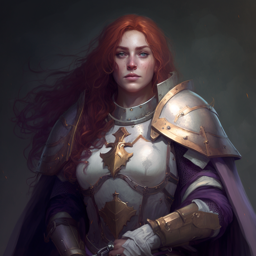

In [12]:
# read image prompt
image = Image.open("/content/woman.png")
image.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-776337758b56>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, height), Image.ANTIALIAS)


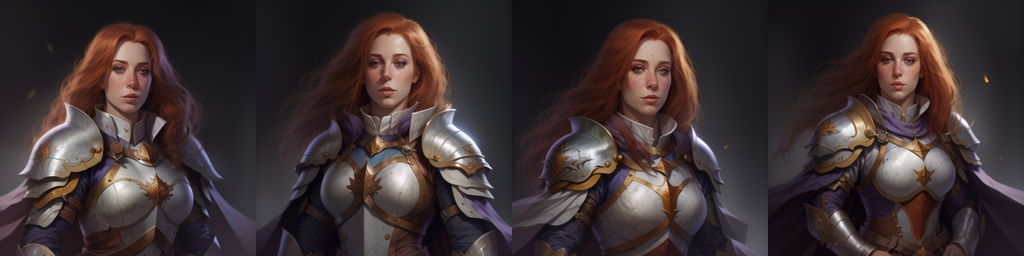

In [15]:
# generate image variations
images = ip_model.generate(pil_image=image,
                           num_samples=4,
                           num_inference_steps=50,
                           seed=42)
concat_resized_images(images)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-776337758b56>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, height), Image.ANTIALIAS)


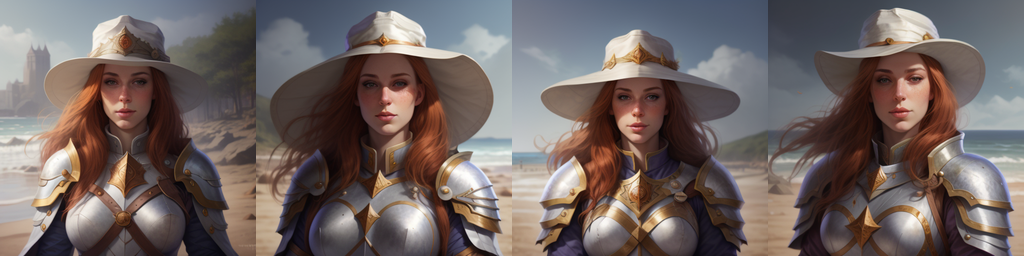

In [16]:
# multimodal prompts
images = ip_model.generate(pil_image=image,
                           num_samples=4,
                           num_inference_steps=50,
                           seed=42,
prompt="best quality, high quality, wearing a hat on the beach",
                           scale=0.6)
concat_resized_images(images)

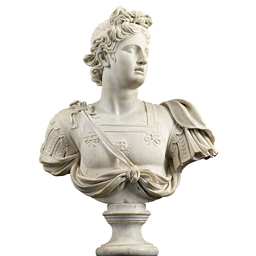

In [17]:
# read image prompt
image = Image.open("/content/statue.png")
image.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-776337758b56>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, height), Image.ANTIALIAS)


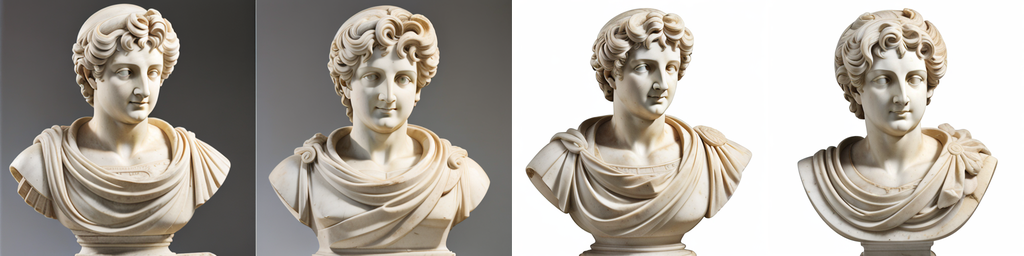

In [18]:
# generate image variations
images = ip_model.generate(pil_image=image,
                           num_samples=4,
                           num_inference_steps=50,
                           seed=42)
concat_resized_images(images)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-14-776337758b56>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, height), Image.ANTIALIAS)


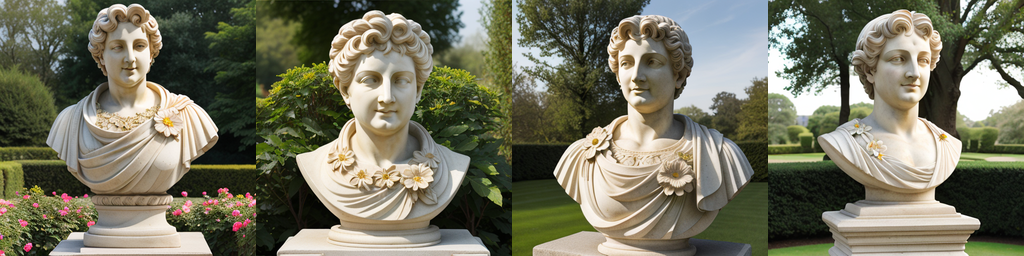

In [19]:
# multimodal prompts
images = ip_model.generate(pil_image=image,
                           num_samples=4,
                           num_inference_steps=50,
                           seed=42,
prompt="best quality, high quality, in a garden with flowers",
                           scale=0.5)
concat_resized_images(images)

In [21]:
del pipe, ip_model
torch.cuda.empty_cache()

In [22]:
# load SD Img2Img pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

<ipython-input-14-776337758b56>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, height), Image.ANTIALIAS)


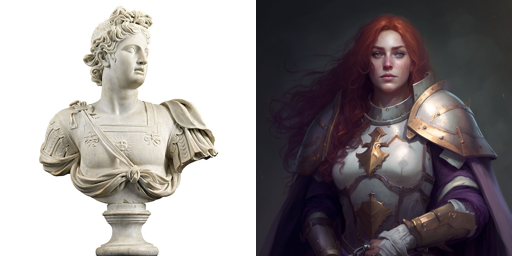

In [24]:
# read image prompt
image = Image.open("/content/statue.png")
g_image = Image.open("/content/woman.png")
concat_resized_images([image.resize((256, 256)), g_image.resize((256, 256))])

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:596: FutureWarning: You have passed 4 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-14-776337758b56>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, height), Image.ANTIALIAS)


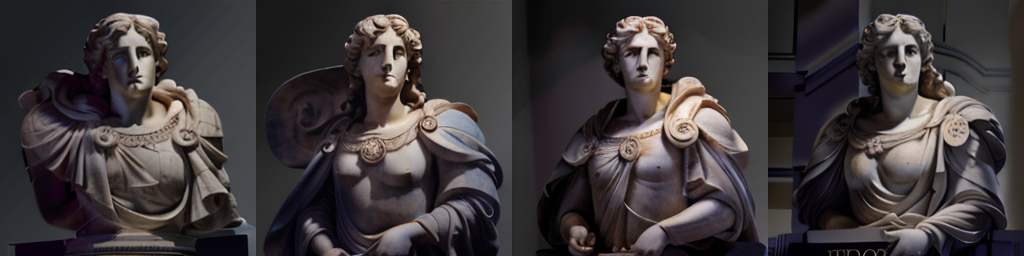

In [25]:
# generate
images = ip_model.generate(pil_image=image,
                           num_samples=4,
                           num_inference_steps=50,
                           seed=42,
                           image=g_image,
                           strength=0.4)
concat_resized_images(images)

In [26]:
del pipe, ip_model
torch.cuda.empty_cache()